In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding,GRU
from keras.models import Sequential

In [3]:
import pandas as pd
import numpy as np
all_data=pd.read_csv('WikiLarge_Train.csv')
from sklearn.model_selection import StratifiedShuffleSplit
sss= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, dev_index in sss.split(all_data, all_data['label']):
    strat_train_set=all_data.iloc[train_index]
    strat_dev_set=all_data.iloc[dev_index]
strat_dev_set['label'].value_counts()/len(strat_dev_set)

0    0.5
1    0.5
Name: label, dtype: float64

In [4]:
all_data.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


In [5]:
all_texts=all_data['original_text'].tolist()
all_labels=all_data['label'].tolist()
MAX_SEQUENCE_LENGTH = 50    #the max seqeunce length
EMBEDDING_DIM = 200    #the size of embedding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(all_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Shape of data tensor: (416768, 50)
Shape of label tensor: (416768, 2)


In [6]:
testing=pd.read_csv('WikiLarge_Test.csv')
all_test=list(testing['original_text'])


In [7]:
len(all_test)

119092

In [8]:
sequences_test = tokenizer.texts_to_sequences(all_test)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [9]:
X_train=data[train_index]
y_train=labels[train_index]
X_dev=data[dev_index]
y_dev=labels[dev_index]

In [23]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 200)           28541000  
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 28,874,794
Trainable params: 28,874,794
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
print(model.metrics_names)
model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=2, batch_size=128)
model.save('lstm.h5')

[]
Epoch 1/2
2605/2605 [==============================] - 4035s 2s/step - loss: 0.5988 - acc: 0.6696 - val_loss: 0.5508 - val_acc: 0.7096
Epoch 2/2
2605/2605 [==============================] - 1992s 765ms/step - loss: 0.5307 - acc: 0.7268 - val_loss: 0.5453 - val_acc: 0.7142


In [1]:
from keras.models import load_model
model = load_model('lstm.h5')

In [10]:
validation_prediction=model.predict(X_dev)

In [35]:
predict_results=model.predict(X_test)

In [11]:
len(validation_prediction)

83354

In [12]:
prediction_validation_all=[]
for i in validation_prediction:
    if i[1]>=i[0]:
        prediction_validation_all.append(1)
    else:
        prediction_validation_all.append(0)
        
        

In [31]:
strat_dev_set['label']

64720     1
221128    0
84183     1
343088    0
65315     1
         ..
21867     1
72075     1
121686    1
268455    0
52008     1
Name: label, Length: 83354, dtype: int64

In [39]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
precision=precision_score(prediction_validation_all, strat_dev_set['label'])
recall=recall_score(prediction_validation_all, strat_dev_set['label'])
f1=f1_score(prediction_validation_all, strat_dev_set['label'])
auc=roc_auc_score(prediction_validation_all, strat_dev_set['label'])

In [47]:
precision

0.777551167310507

In [48]:
recall

0.6900619663124721

In [49]:
f1

0.7311988086373791

In [50]:
auc

0.717657587173492

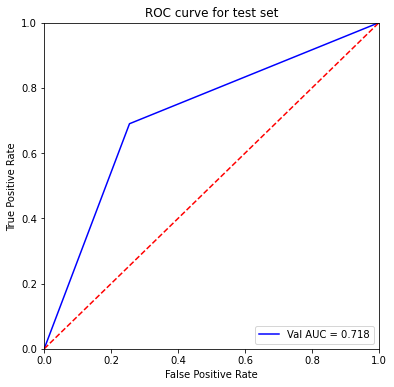

In [45]:
from sklearn import metrics
import pylab as plt
fpr, tpr, threshold = metrics.roc_curve(prediction_validation_all, strat_dev_set['label'].tolist())
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('ROC curve for test set')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [36]:
len(X_test)

119092

In [37]:
len(predict_results)

119092

In [38]:
result_1=[]
result_2=[]
for i in range(len(predict_results)):
    if predict_results[i][0]>predict_results[i][1]:
        result_1.append(int(0))
        
        
    else:
        result_1.append(int(1))
        

In [39]:
len(result_1)

119092

In [40]:
result_1=pd.DataFrame({'id':list(testing['id']), 'label':result_1})
result_1.to_csv('results_LSTM1.csv',index=None)